Key to results data:

**Feature engineering**
```python
df2['HBP']= 10*df2['HY'] + 25*df2['HR']
df2['ABP']= 10*df2['AY'] + 25*df2['AR']

df2['FTHGDif']= df2.FTHG - df2.FTAG
df2['HTHGDif']= df2.HTHG - df2.HTAG

df2['shotsDiff'] = df2.HS - df2.AS
df2['shotsonTargetDiff'] = df2.HST - df2.AST
#df2['hitWoodworkDiff'] = df2.HHW - df2.AHW
df2['cornersDiff'] = df2.HC - df2.AC
df2['foulsCommittedDiff'] = df2.HF - df2.AF
#df2['freeKickConcededDiff'] = df2.HFKC - df2.AFKC
#df2['offsideDiff'] = df2.HO - df2.AO
df2['yellowcardDiff'] = df2.HY - df2.AY
df2['redcardDiff'] = df2.HR - df2.AR
df2['bookingptsDiff'] = df2.HBP - df2.ABP

#finalresult key using random label vs EPL label
FTR_res_keyH = {'H':1, 'A':-1, 'D':0}
EPL_res_keyH = {'H':3, 'A':0, 'D':1}
FTR_res_keyA = {'H':-1, 'A':1, 'D':0}
EPL_res_keyA = {'H':0, 'A':3, 'D':1}

#results WRT to the hometeam and awayteam
df2['resultH'] = df2['FTR'].map(FTR_res_keyH)
df2['EPLresultH'] = df2['FTR'].map(EPL_res_keyH)
df2['resultA'] = df2['FTR'].map(FTR_res_keyA)
df2['EPLresultA'] = df2['FTR'].map(EPL_res_keyA)

HomePtTally_df = df2.groupby('HomeTeam')['HomeTeam', 'AwayTeam',
       'resultH', 'EPLresultH' ].sum().sort_values('EPLresultH', ascending=False)
AwayPtTally_df = df2.groupby('AwayTeam')['HomeTeam', 'AwayTeam',
        'resultA', 'EPLresultA'].sum().sort_values('EPLresultA', ascending=False)
xx = pd.concat([HomePtTally_df, AwayPtTally_df], axis=1)
xx['EPLresult']= xx.EPLresultA + xx.EPLresultH
xx = xx.drop(['resultH','resultA'], axis=1)
xx.sort_values('EPLresult', ascending=False) #EPL_16/17 table
xx['EPLresult'].sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
```
Div = League Division <br>
Date = Match Date (dd/mm/yy)<br>
HomeTeam = Home Team<br>
AwayTeam = Away Team<br>
FTHG and HG = Full Time Home Team Goals<br>
FTAG and AG = Full Time Away Team Goals<br>
FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)<br>
HTHG = Half Time Home Team Goals<br>
HTAG = Half Time Away Team Goals<br>
HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)<br>
<br>
Match Statistics (where available)<br><br>
Attendance = Crowd Attendance<br>
Referee = Match Referee<br>
HS = Home Team Shots<br>
AS = Away Team Shots<br>
HST = Home Team Shots on Target<br>
AST = Away Team Shots on Target<br>
HHW = Home Team Hit Woodwork<br>
AHW = Away Team Hit Woodwork<br>
HC = Home Team Corners<br>
AC = Away Team Corners<br>
HF = Home Team Fouls Committed<br>
AF = Away Team Fouls Committed<br>
HFKC = Home Team Free Kicks Conceded<br>
AFKC = Away Team Free Kicks Conceded<br>
HO = Home Team Offsides<br>
AO = Away Team Offsides<br>
HY = Home Team Yellow Cards<br>
AY = Away Team Yellow Cards<br>
HR = Home Team Red Cards<br>
AR = Away Team Red Cards<br>
HBP = Home Team Bookings Points (10 = yellow, 25 = red)<br>
ABP = Away Team Bookings Points (10 = yellow, 25 = red)<br>
<br>
<br>
Note that Free Kicks Conceeded includes fouls, offsides and any other offense commmitted and
will always be equal to or higher than the number of fouls. Fouls make up the vast majority
of Free Kicks Conceded. Free Kicks Conceded are shown when specific data on Fouls are not
available (France 2nd, Belgium 1st and Greece 1st divisions).
Note also that English and Scottish yellow cards do not include the initial yellow card when
a second is shown to a player converting it into a red, but this is included as a yellow
(plus red) for European games.

In [1]:
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import scipy.stats as scs
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
df = pd.read_csv('data/football_data_co_UK/2016_17_epl.csv')

In [3]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,13/08/16,Burnley,Swansea,0,1,A,0,0,D,J Moss,10,17,3,9,10,14,7,4,3,2,0,0,2.40,3.3,3.25,2.45,3.1,2.95,2.50,3.3,2.65,2.45,3.25,3.10,2.47,3.32,3.19,2.50,3.20,2.90,2.50,3.2,3.25,55,2.55,2.43,3.35,3.21,3.30,3.10,40,2.40,2.30,1.68,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
1,E0,13/08/16,Crystal Palace,West Brom,0,1,A,0,0,D,C Pawson,14,13,4,3,12,15,3,6,2,2,0,0,2.00,3.3,4.50,2.00,3.2,3.90,2.10,3.3,3.30,2.00,3.25,4.33,2.06,3.29,4.32,2.05,3.10,4.00,2.00,3.3,4.40,56,2.10,2.01,3.40,3.23,4.50,4.16,38,2.68,2.50,1.60,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2,E0,13/08/16,Everton,Tottenham,1,1,D,1,0,H,M Atkinson,12,13,6,4,10,14,5,6,0,0,0,0,3.20,3.4,2.40,2.95,3.2,2.40,2.65,3.3,2.50,3.10,3.40,2.40,3.25,3.43,2.37,3.10,3.10,2.40,3.25,3.4,2.38,55,3.30,3.12,3.45,3.32,2.50,2.36,41,2.12,2.05,1.87,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
3,E0,13/08/16,Hull,Leicester,2,1,H,1,0,H,M Dean,14,18,5,5,8,17,5,3,2,2,0,0,4.50,3.6,1.91,4.33,3.4,1.90,3.30,3.3,2.10,4.50,3.50,1.91,4.43,3.55,1.95,4.20,3.25,1.95,4.40,3.5,1.95,55,4.50,4.17,3.60,3.43,2.33,1.95,40,2.30,2.19,1.74,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
4,E0,13/08/16,Man City,Sunderland,2,1,H,1,0,H,R Madley,16,7,4,3,11,14,9,6,1,2,0,0,1.25,6.5,15.00,1.22,6.0,11.50,1.25,5.5,10.30,1.25,6.50,13.00,1.27,6.48,13.15,1.25,5.50,13.00,1.25,6.5,15.00,56,1.30,1.25,6.80,6.11,15.00,12.55,39,1.56,1.53,2.67,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50


In [4]:
df.shape

(380, 65)

In [5]:
df2 = df.copy()

In [6]:
df2.columns, len(df2.columns)

(Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
        'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
        'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
        'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA',
        'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH',
        'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5',
        'BbMx<2.5', 'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH',
        'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD', 'PSCA'],
       dtype='object'), 65)

In [7]:
df2.HomeTeam.unique(), len(df2.HomeTeam.unique())

(array(['Burnley', 'Crystal Palace', 'Everton', 'Hull', 'Man City',
        'Middlesbrough', 'Southampton', 'Arsenal', 'Bournemouth',
        'Chelsea', 'Man United', 'Leicester', 'Stoke', 'Swansea',
        'Tottenham', 'Watford', 'West Brom', 'Sunderland', 'West Ham',
        'Liverpool'], dtype=object), 20)

In [8]:
drop_cols = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD',
        'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA',
        'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH',
        'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5',
        'BbMx<2.5', 'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH',
        'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD', 'PSCA']
df2 = df2.drop(drop_cols, axis=1)

In [9]:
df2.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,13/08/16,Burnley,Swansea,0,1,A,0,0,D,J Moss,10,17,3,9,10,14,7,4,3,2,0,0
1,E0,13/08/16,Crystal Palace,West Brom,0,1,A,0,0,D,C Pawson,14,13,4,3,12,15,3,6,2,2,0,0
2,E0,13/08/16,Everton,Tottenham,1,1,D,1,0,H,M Atkinson,12,13,6,4,10,14,5,6,0,0,0,0
3,E0,13/08/16,Hull,Leicester,2,1,H,1,0,H,M Dean,14,18,5,5,8,17,5,3,2,2,0,0
4,E0,13/08/16,Man City,Sunderland,2,1,H,1,0,H,R Madley,16,7,4,3,11,14,9,6,1,2,0,0


In [10]:
df2['HBP']= 10*df2['HY'] + 25*df2['HR']
df2['ABP']= 10*df2['AY'] + 25*df2['AR']

In [11]:
df2.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HBP,ABP
0,E0,13/08/16,Burnley,Swansea,0,1,A,0,0,D,J Moss,10,17,3,9,10,14,7,4,3,2,0,0,30,20
1,E0,13/08/16,Crystal Palace,West Brom,0,1,A,0,0,D,C Pawson,14,13,4,3,12,15,3,6,2,2,0,0,20,20
2,E0,13/08/16,Everton,Tottenham,1,1,D,1,0,H,M Atkinson,12,13,6,4,10,14,5,6,0,0,0,0,0,0
3,E0,13/08/16,Hull,Leicester,2,1,H,1,0,H,M Dean,14,18,5,5,8,17,5,3,2,2,0,0,20,20
4,E0,13/08/16,Man City,Sunderland,2,1,H,1,0,H,R Madley,16,7,4,3,11,14,9,6,1,2,0,0,10,20


In [54]:
df2['FTHGDif']= df2.FTHG - df2.FTAG
df2['HTHGDif']= df2.HTHG - df2.HTAG

In [13]:
df2.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HBP,ABP,FTHGDif,HTHGDif
0,E0,13/08/16,Burnley,Swansea,0,1,A,0,0,D,J Moss,10,17,3,9,10,14,7,4,3,2,0,0,30,20,-1,0
1,E0,13/08/16,Crystal Palace,West Brom,0,1,A,0,0,D,C Pawson,14,13,4,3,12,15,3,6,2,2,0,0,20,20,-1,0
2,E0,13/08/16,Everton,Tottenham,1,1,D,1,0,H,M Atkinson,12,13,6,4,10,14,5,6,0,0,0,0,0,0,0,1
3,E0,13/08/16,Hull,Leicester,2,1,H,1,0,H,M Dean,14,18,5,5,8,17,5,3,2,2,0,0,20,20,1,1
4,E0,13/08/16,Man City,Sunderland,2,1,H,1,0,H,R Madley,16,7,4,3,11,14,9,6,1,2,0,0,10,20,1,1


In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 27 columns):
Div         380 non-null object
Date        380 non-null object
HomeTeam    380 non-null object
AwayTeam    380 non-null object
FTHG        380 non-null int64
FTAG        380 non-null int64
FTR         380 non-null object
HTHG        380 non-null int64
HTAG        380 non-null int64
HTR         380 non-null object
Referee     380 non-null object
HS          380 non-null int64
AS          380 non-null int64
HST         380 non-null int64
AST         380 non-null int64
HF          380 non-null int64
AF          380 non-null int64
HC          380 non-null int64
AC          380 non-null int64
HY          380 non-null int64
AY          380 non-null int64
HR          380 non-null int64
AR          380 non-null int64
HBP         380 non-null int64
ABP         380 non-null int64
FTHGDif     380 non-null int64
HTHGDif     380 non-null int64
dtypes: int64(20), object(7)
memory usage: 80.2+ KB

In [15]:
df2.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HBP,ABP,FTHGDif,HTHGDif
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1.597368,1.202632,0.705263,0.510526,14.013158,11.484211,4.813158,3.855263,11.063158,11.657895,5.678947,4.734211,1.744737,1.886842,0.055263,0.052632,18.828947,20.184211,0.394737,0.194737
std,1.306971,1.227862,0.857974,0.753108,5.878033,5.019462,2.817086,2.383452,3.468853,3.556378,3.084916,2.702562,1.256371,1.301647,0.240050,0.223591,13.797813,14.224649,1.907346,1.197611
min,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,-4.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,9.000000,9.000000,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000,10.000000,10.000000,-1.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,11.000000,4.000000,3.000000,11.000000,12.000000,5.000000,4.000000,2.000000,2.000000,0.000000,0.000000,20.000000,20.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,6.000000,5.000000,13.000000,14.000000,8.000000,6.000000,3.000000,3.000000,0.000000,0.000000,30.000000,30.000000,2.000000,1.000000
max,6.000000,7.000000,4.000000,4.000000,37.000000,29.000000,17.000000,15.000000,24.000000,24.000000,19.000000,15.000000,6.000000,6.000000,2.000000,1.000000,70.000000,85.000000,5.000000,4.000000


In [16]:
df2.groupby('HomeTeam')['HS'].sum()

HomeTeam
Arsenal           329
Bournemouth       253
Burnley           210
Chelsea           316
Crystal Palace    224
Everton           277
Hull              208
Leicester         240
Liverpool         331
Man City          336
Man United        337
Middlesbrough     205
Southampton       299
Stoke             229
Sunderland        214
Swansea           223
Tottenham         373
Watford           231
West Brom         220
West Ham          270
Name: HS, dtype: int64

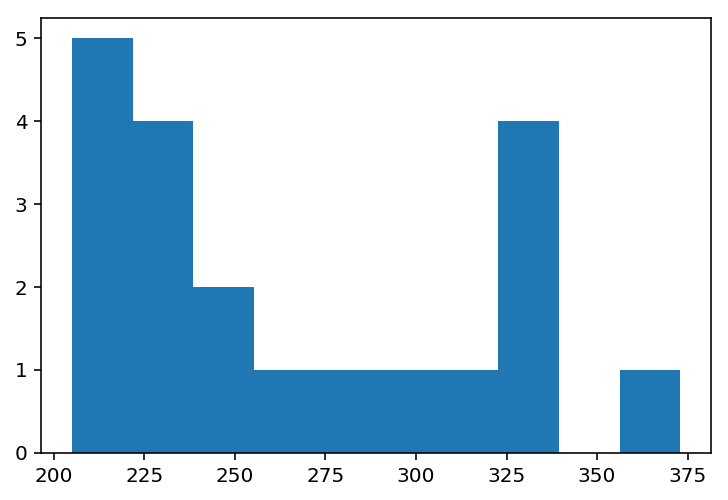

In [17]:
plt.hist(df2.groupby('HomeTeam')['HS'].sum(), bins=10)
plt.show()

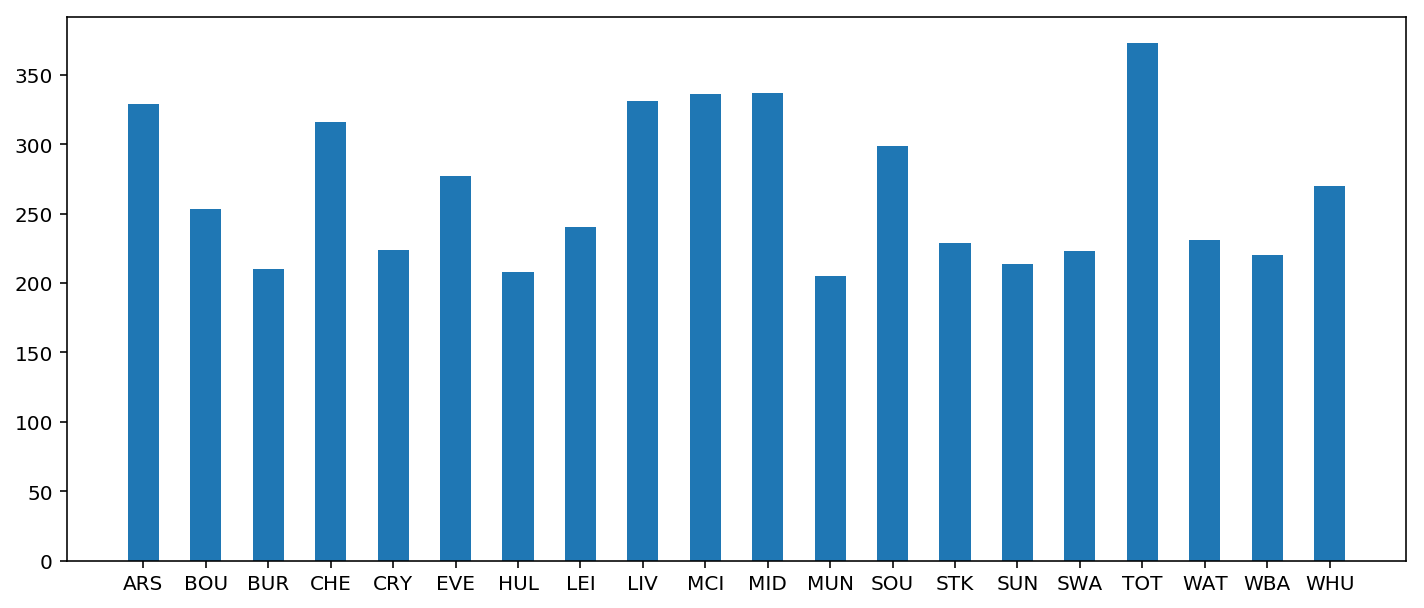

In [18]:
teams = {'Burnley':'BUR', 'Crystal Palace':'CRY', 'Everton':'EVE', 
         'Hull':'HUL', 'Man City':'MCI','Middlesbrough':'MID', 
         'Southampton':'SOU', 'Arsenal':'ARS', 'Bournemouth':'BOU',
         'Chelsea':'CHE', 'Man United':'MUN', 'Leicester':'LEI', 
         'Stoke':'STK', 'Swansea':'SWA','Tottenham':'TOT', 
         'Watford':'WAT', 'West Brom':'WBA', 'Sunderland':'SUN',
         'West Ham':'WHU','Liverpool': 'LIV'}
ind = np.arange(20)
plt.figure(figsize=(12,5))
plt.bar(ind, df2.groupby('HomeTeam')['HS'].sum(), width=0.5 )
plt.xticks(ind, sorted(teams.values()))
plt.show()

In [19]:
df2.groupby('HomeTeam')['HS'].sum().sort_values(ascending=False)

HomeTeam
Tottenham         373
Man United        337
Man City          336
Liverpool         331
Arsenal           329
Chelsea           316
Southampton       299
Everton           277
West Ham          270
Bournemouth       253
Leicester         240
Watford           231
Stoke             229
Crystal Palace    224
Swansea           223
West Brom         220
Sunderland        214
Burnley           210
Hull              208
Middlesbrough     205
Name: HS, dtype: int64

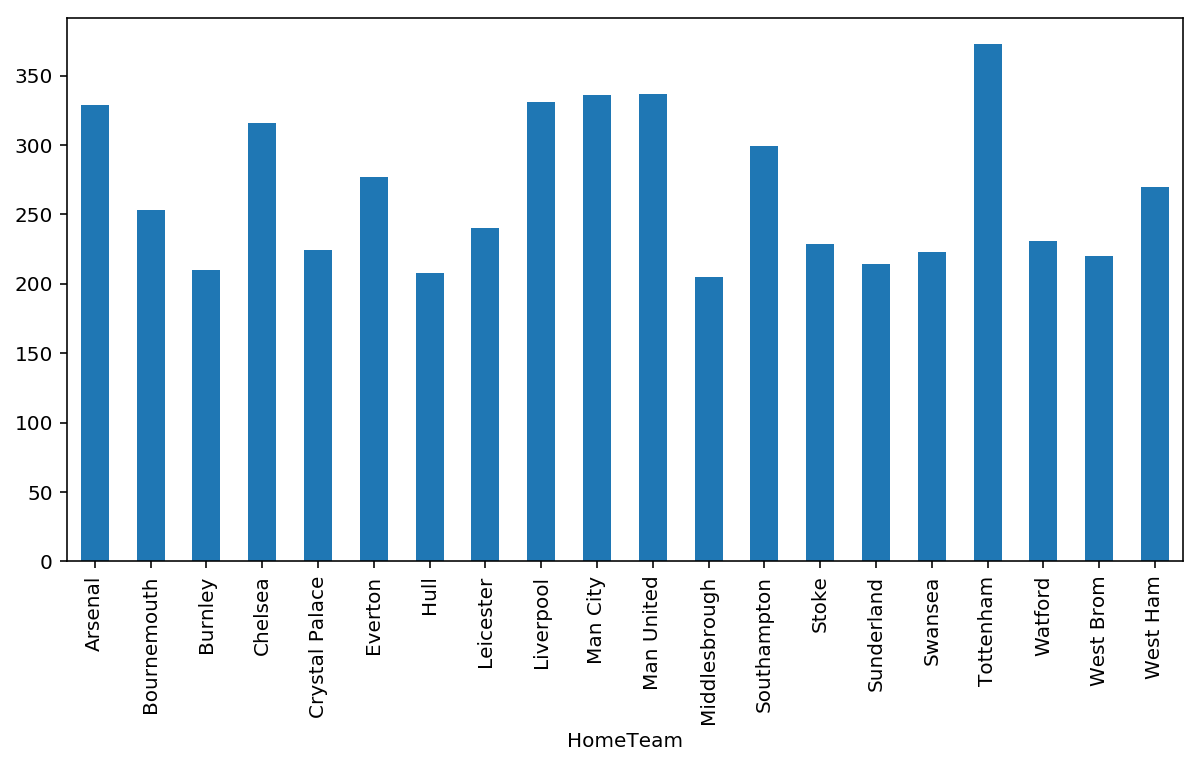

In [20]:
df2.groupby('HomeTeam')['HS'].sum().plot(kind='bar', figsize=(10,5))

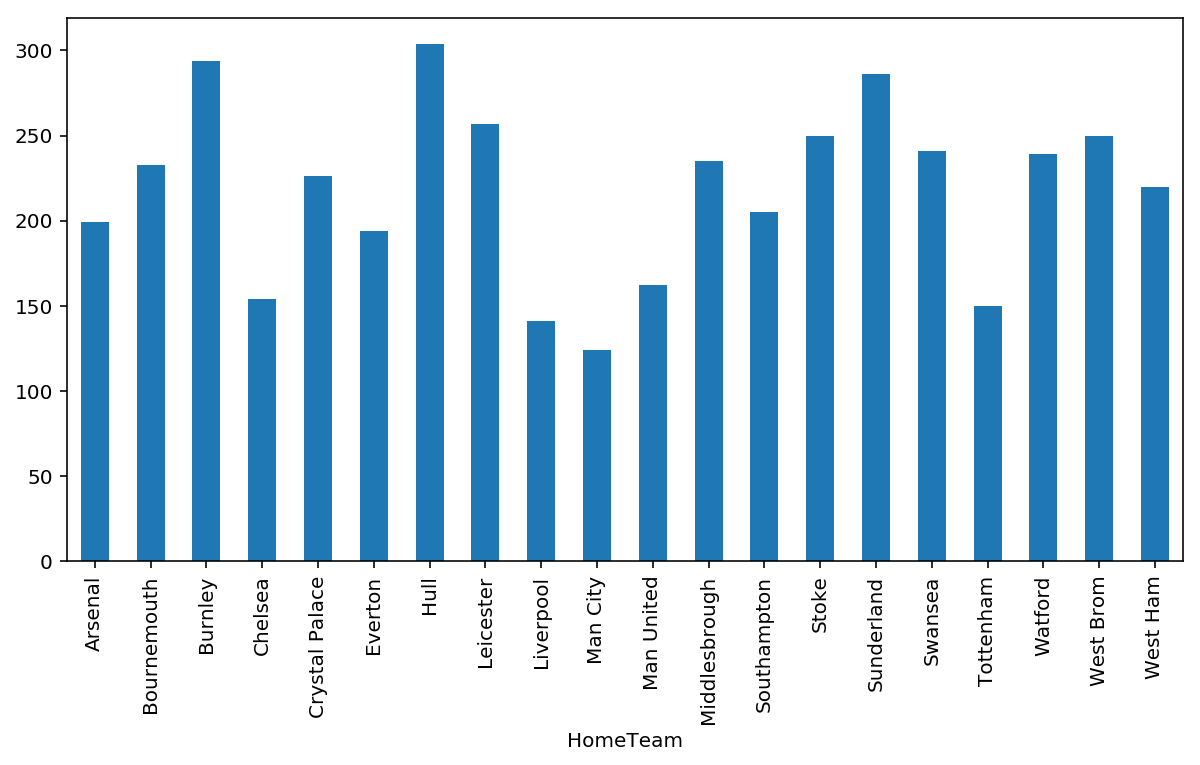

In [21]:
df2.groupby('HomeTeam')['AS'].sum().plot(kind='bar', figsize=(10,5))

In [22]:
df2['shotsDiff'] = df2.HS - df2.AS
df2['shotsonTargetDiff'] = df2.HST - df2.AST
#df2['hitWoodworkDiff'] = df2.HHW - df2.AHW
df2['cornersDiff'] = df2.HC - df2.AC
df2['foulsCommittedDiff'] = df2.HF - df2.AF
#df2['freeKickConcededDiff'] = df2.HFKC - df2.AFKC
#df2['offsideDiff'] = df2.HO - df2.AO
df2['yellowcardDiff'] = df2.HY - df2.AY
df2['redcardDiff'] = df2.HR - df2.AR
df2['bookingptsDiff'] = df2.HBP - df2.ABP

In [23]:
df2.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP', 'FTHGDif', 'HTHGDif',
       'shotsDiff', 'shotsonTargetDiff', 'cornersDiff', 'foulsCommittedDiff',
       'yellowcardDiff', 'redcardDiff', 'bookingptsDiff'],
      dtype='object')

In [24]:
df2.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HBP,ABP,FTHGDif,HTHGDif,shotsDiff,shotsonTargetDiff,cornersDiff,foulsCommittedDiff,yellowcardDiff,redcardDiff,bookingptsDiff
0,E0,13/08/16,Burnley,Swansea,0,1,A,0,0,D,J Moss,10,17,3,9,10,14,7,4,3,2,0,0,30,20,-1,0,-7,-6,3,-4,1,0,10
1,E0,13/08/16,Crystal Palace,West Brom,0,1,A,0,0,D,C Pawson,14,13,4,3,12,15,3,6,2,2,0,0,20,20,-1,0,1,1,-3,-3,0,0,0
2,E0,13/08/16,Everton,Tottenham,1,1,D,1,0,H,M Atkinson,12,13,6,4,10,14,5,6,0,0,0,0,0,0,0,1,-1,2,-1,-4,0,0,0
3,E0,13/08/16,Hull,Leicester,2,1,H,1,0,H,M Dean,14,18,5,5,8,17,5,3,2,2,0,0,20,20,1,1,-4,0,2,-9,0,0,0
4,E0,13/08/16,Man City,Sunderland,2,1,H,1,0,H,R Madley,16,7,4,3,11,14,9,6,1,2,0,0,10,20,1,1,9,1,3,-3,-1,0,-10


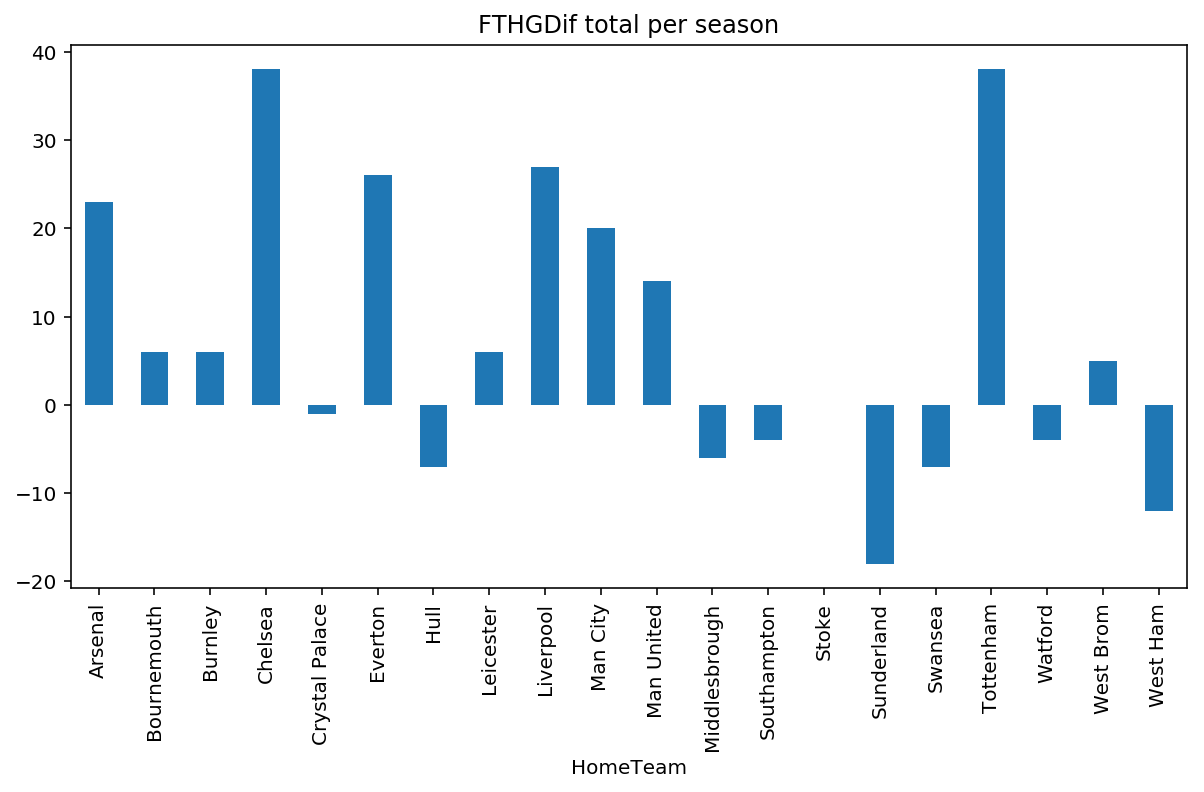

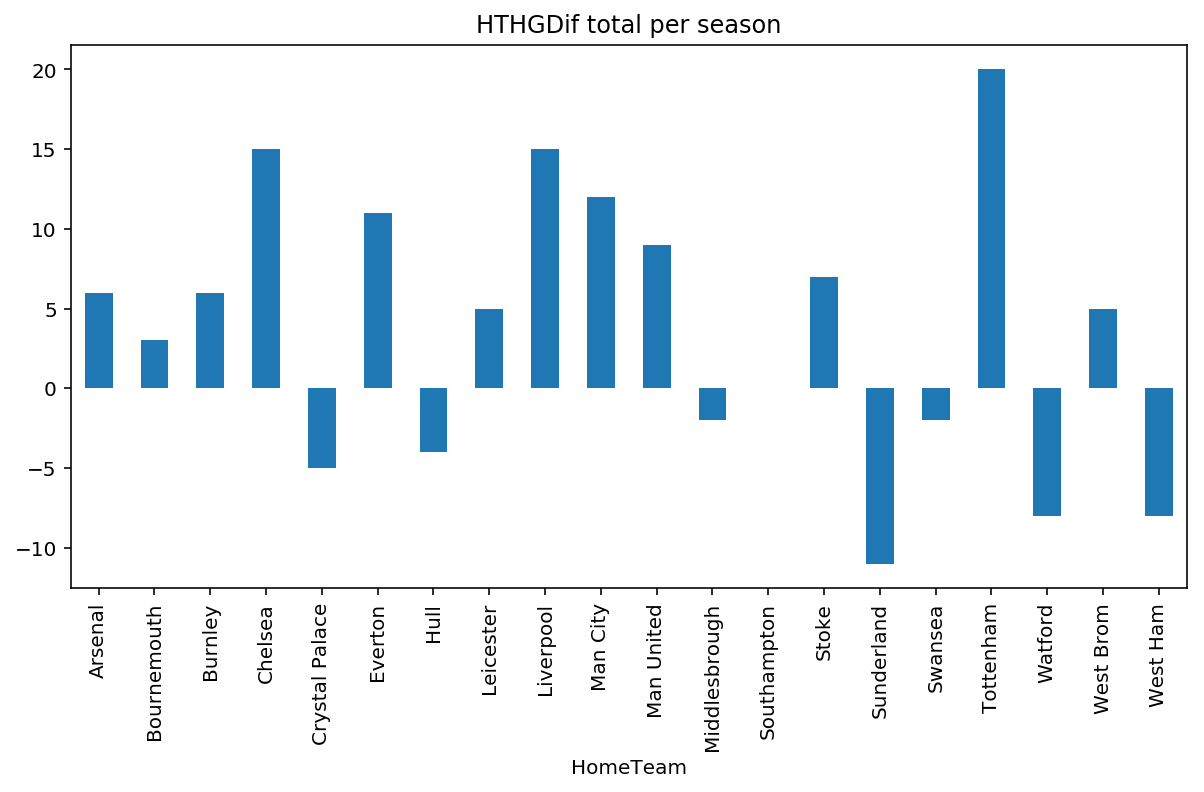

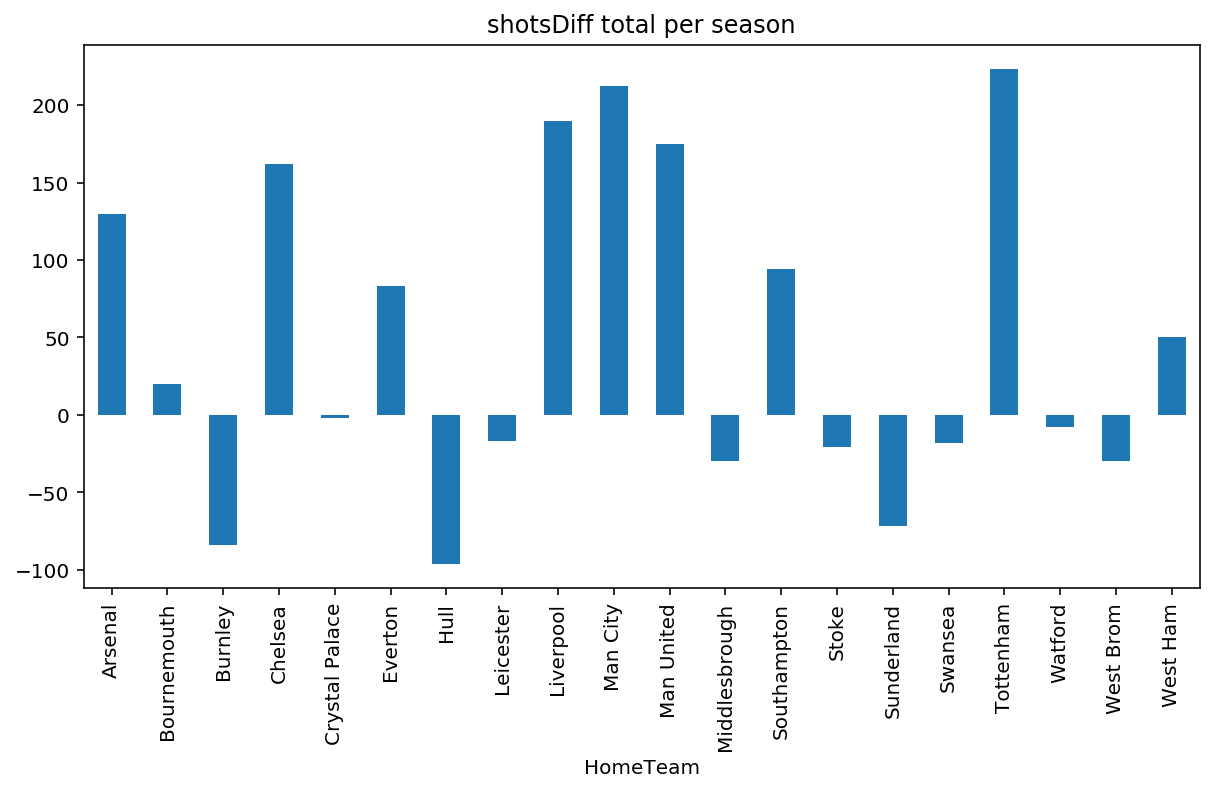

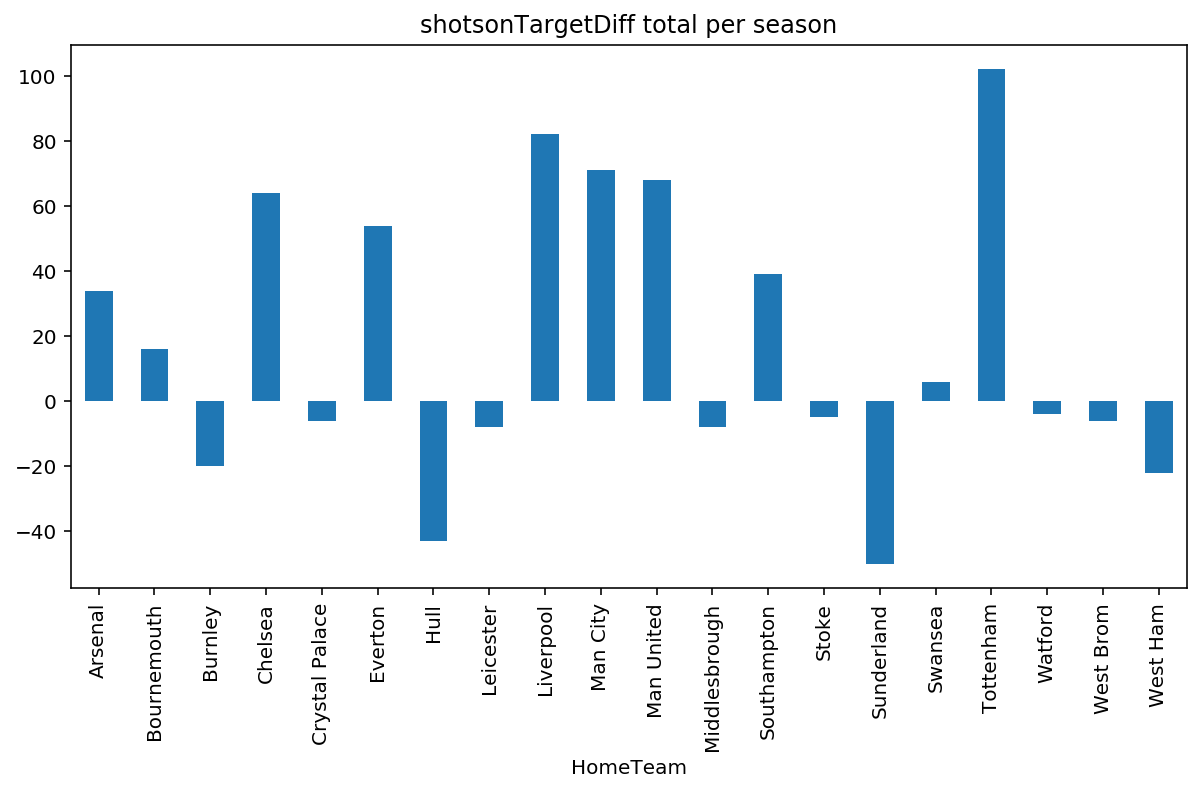

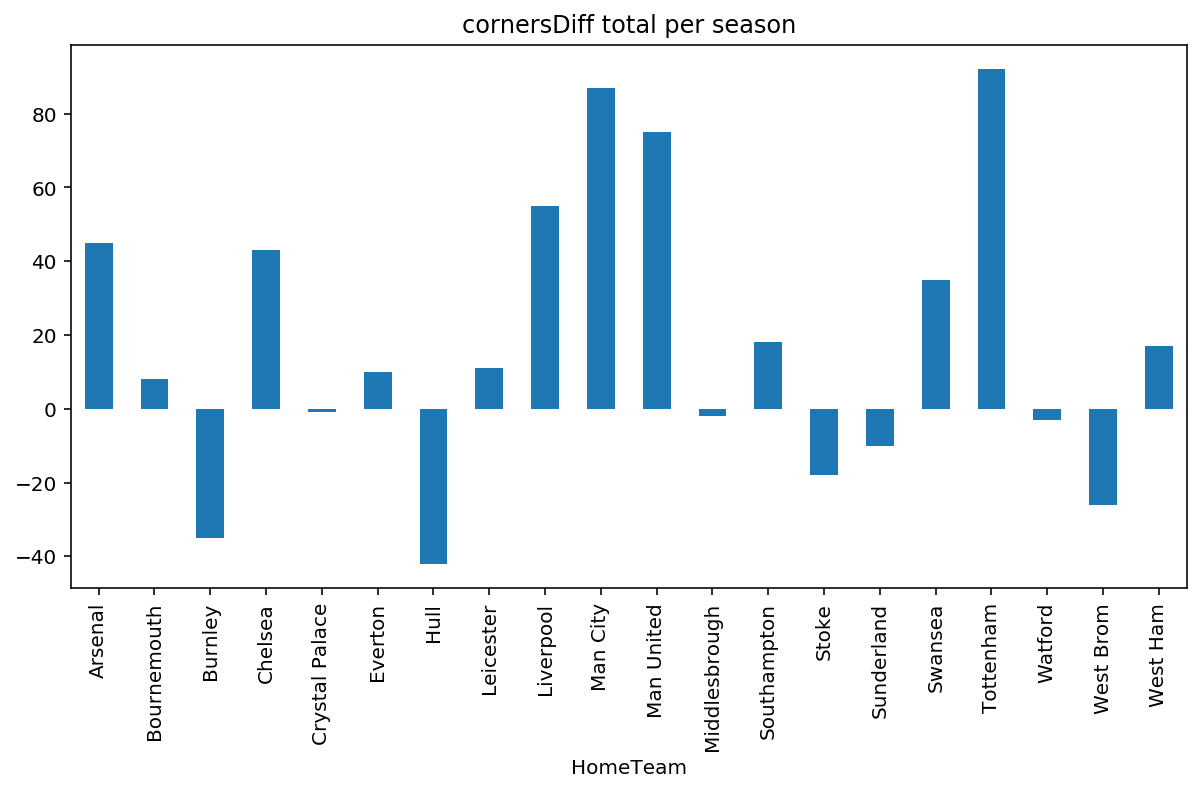

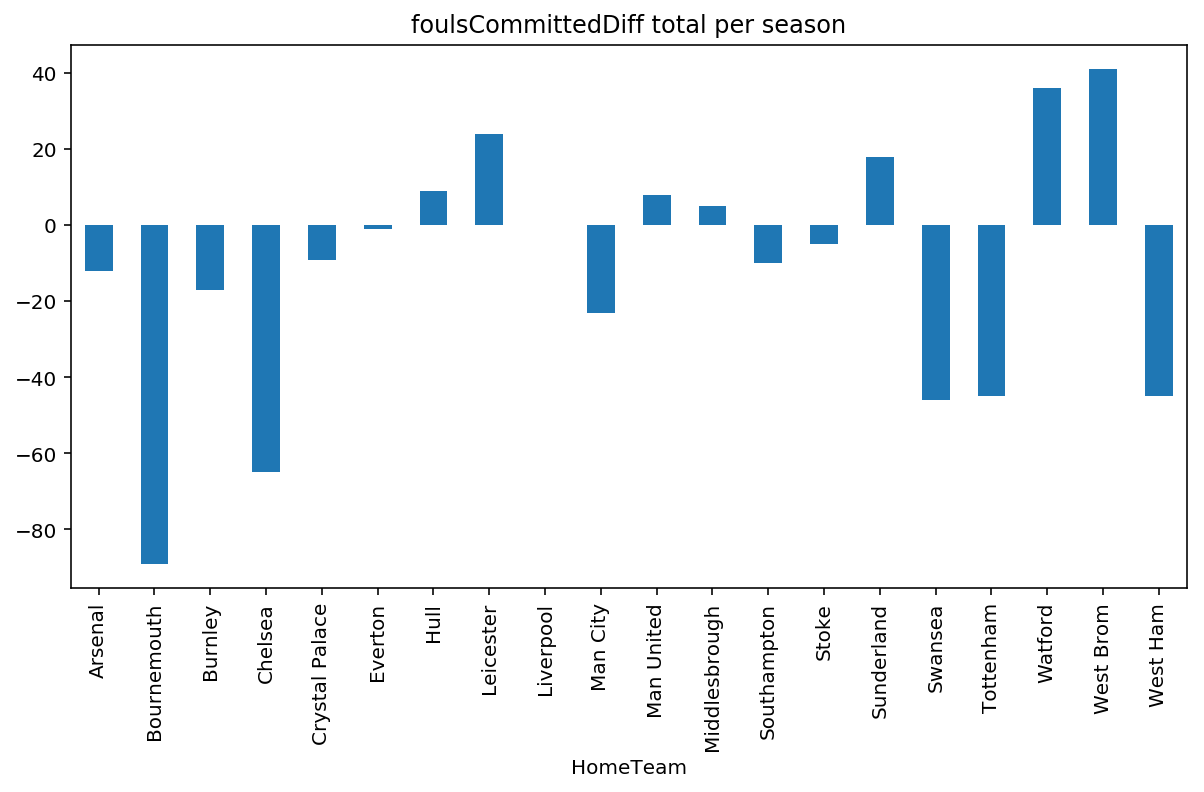

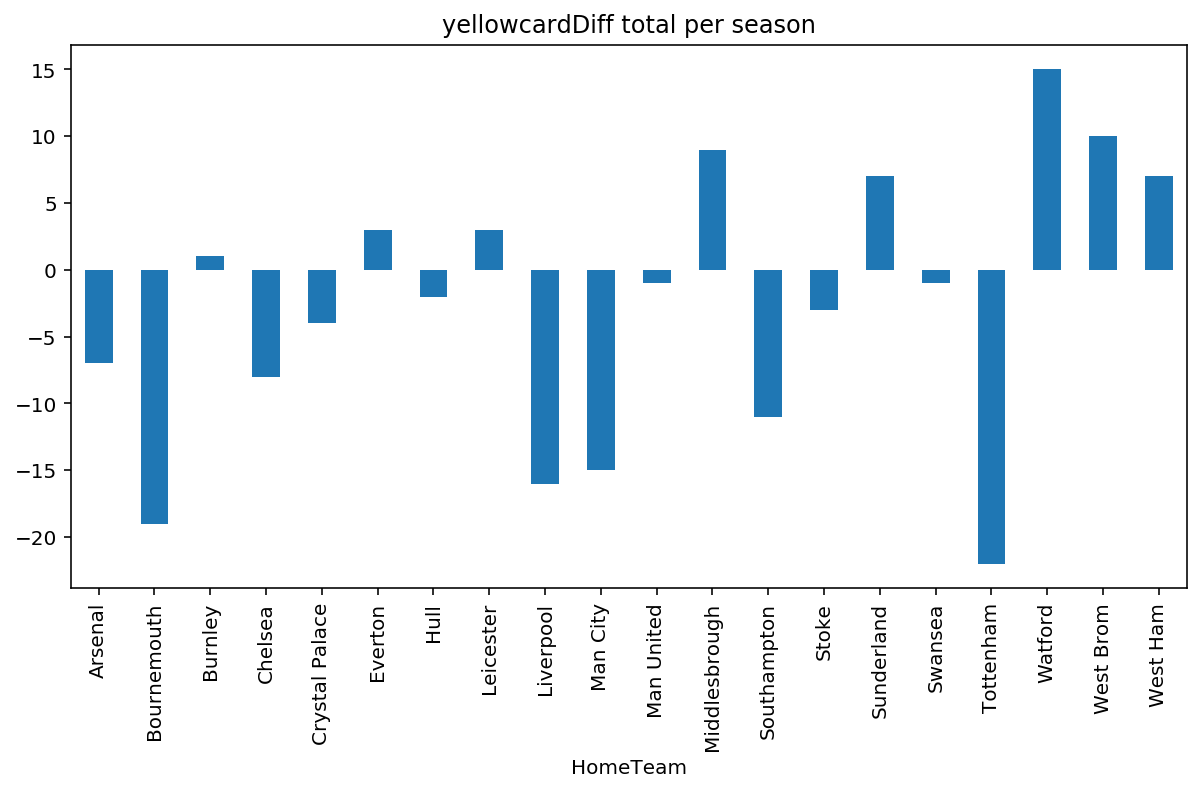

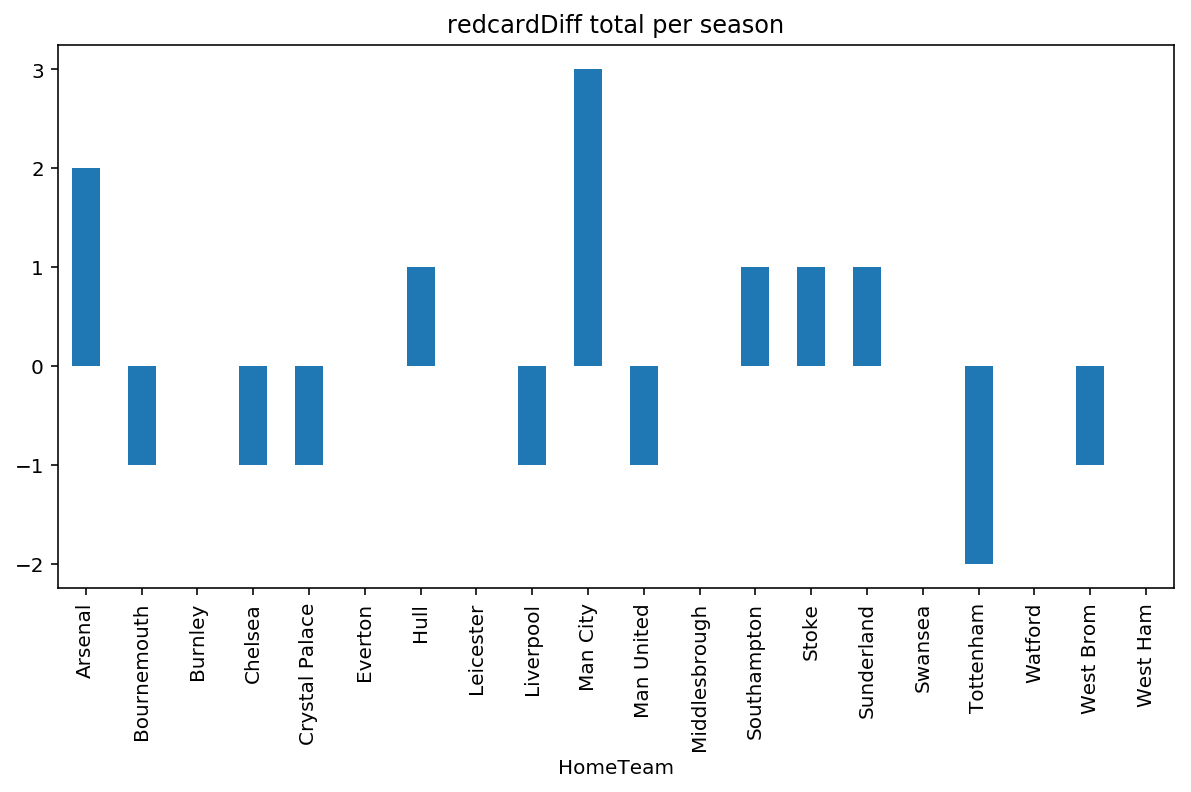

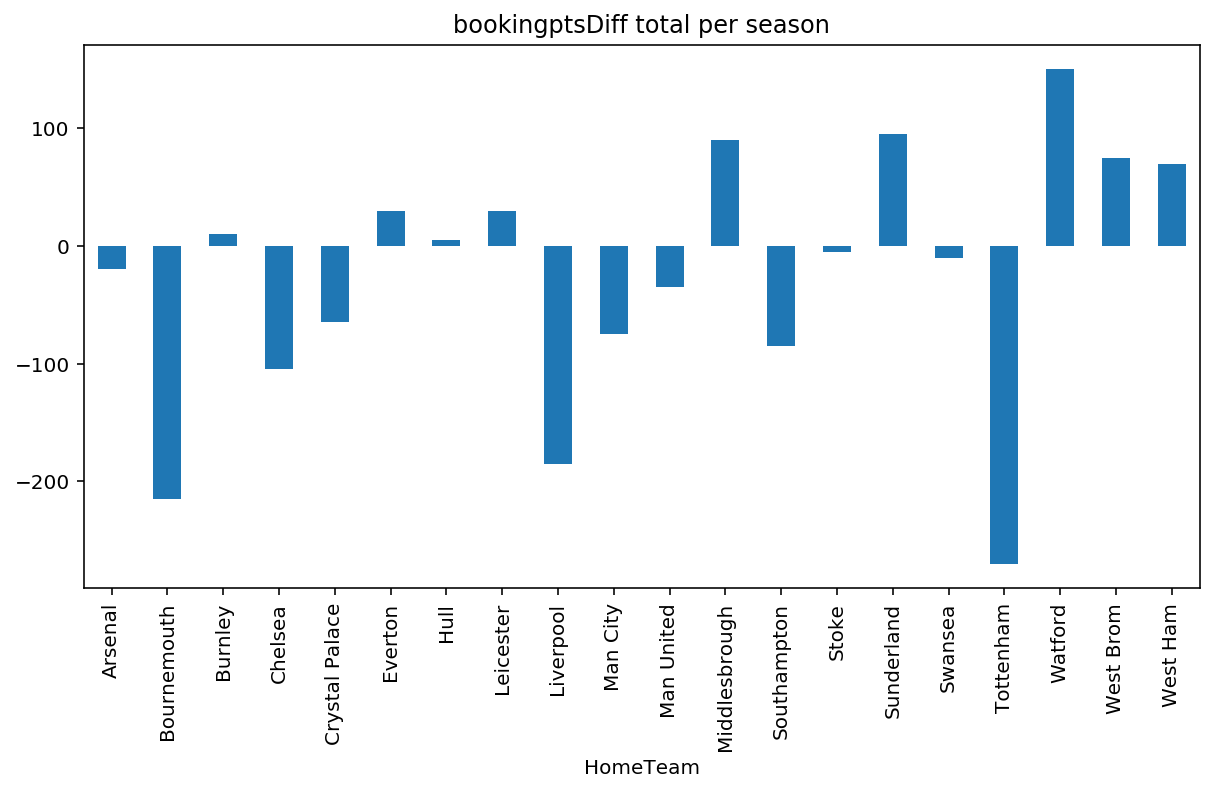

In [25]:
diff_cols = ['FTHGDif', 'HTHGDif','shotsDiff', 'shotsonTargetDiff',
             'cornersDiff', 'foulsCommittedDiff','yellowcardDiff',
             'redcardDiff', 'bookingptsDiff']
for col in diff_cols:
    df2.groupby('HomeTeam')[col].sum().plot(kind='bar', figsize=(10,5))
    plt.title(col + ' total per season')
    plt.show()

In [26]:
diff_cols = ['FTHGDif', 'HTHGDif','shotsDiff', 'shotsonTargetDiff',
             'cornersDiff', 'foulsCommittedDiff','yellowcardDiff',
             'redcardDiff', 'bookingptsDiff']
for col in diff_cols:
    df2[col+'_norm'] = (df2[col] - np.min(df2[col]))/ (np.max(df2[col])  - np.min(df2[col]))

In [27]:
df2.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HBP,ABP,FTHGDif,HTHGDif,shotsDiff,shotsonTargetDiff,cornersDiff,foulsCommittedDiff,yellowcardDiff,redcardDiff,bookingptsDiff,FTHGDif_norm,HTHGDif_norm,shotsDiff_norm,shotsonTargetDiff_norm,cornersDiff_norm,foulsCommittedDiff_norm,yellowcardDiff_norm,redcardDiff_norm,bookingptsDiff_norm
0,E0,13/08/16,Burnley,Swansea,0,1,A,0,0,D,J Moss,10,17,3,9,10,14,7,4,3,2,0,0,30,20,-1,0,-7,-6,3,-4,1,0,10,0.454545,0.500,0.301887,0.16,0.53125,0.391304,0.6,0.333333,0.625000
1,E0,13/08/16,Crystal Palace,West Brom,0,1,A,0,0,D,C Pawson,14,13,4,3,12,15,3,6,2,2,0,0,20,20,-1,0,1,1,-3,-3,0,0,0,0.454545,0.500,0.452830,0.44,0.34375,0.434783,0.5,0.333333,0.541667
2,E0,13/08/16,Everton,Tottenham,1,1,D,1,0,H,M Atkinson,12,13,6,4,10,14,5,6,0,0,0,0,0,0,0,1,-1,2,-1,-4,0,0,0,0.545455,0.625,0.415094,0.48,0.40625,0.391304,0.5,0.333333,0.541667
3,E0,13/08/16,Hull,Leicester,2,1,H,1,0,H,M Dean,14,18,5,5,8,17,5,3,2,2,0,0,20,20,1,1,-4,0,2,-9,0,0,0,0.636364,0.625,0.358491,0.40,0.50000,0.173913,0.5,0.333333,0.541667
4,E0,13/08/16,Man City,Sunderland,2,1,H,1,0,H,R Madley,16,7,4,3,11,14,9,6,1,2,0,0,10,20,1,1,9,1,3,-3,-1,0,-10,0.636364,0.625,0.603774,0.44,0.53125,0.434783,0.4,0.333333,0.458333


In [28]:
df2.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP', 'FTHGDif', 'HTHGDif',
       'shotsDiff', 'shotsonTargetDiff', 'cornersDiff', 'foulsCommittedDiff',
       'yellowcardDiff', 'redcardDiff', 'bookingptsDiff', 'FTHGDif_norm',
       'HTHGDif_norm', 'shotsDiff_norm', 'shotsonTargetDiff_norm',
       'cornersDiff_norm', 'foulsCommittedDiff_norm', 'yellowcardDiff_norm',
       'redcardDiff_norm', 'bookingptsDiff_norm'],
      dtype='object')

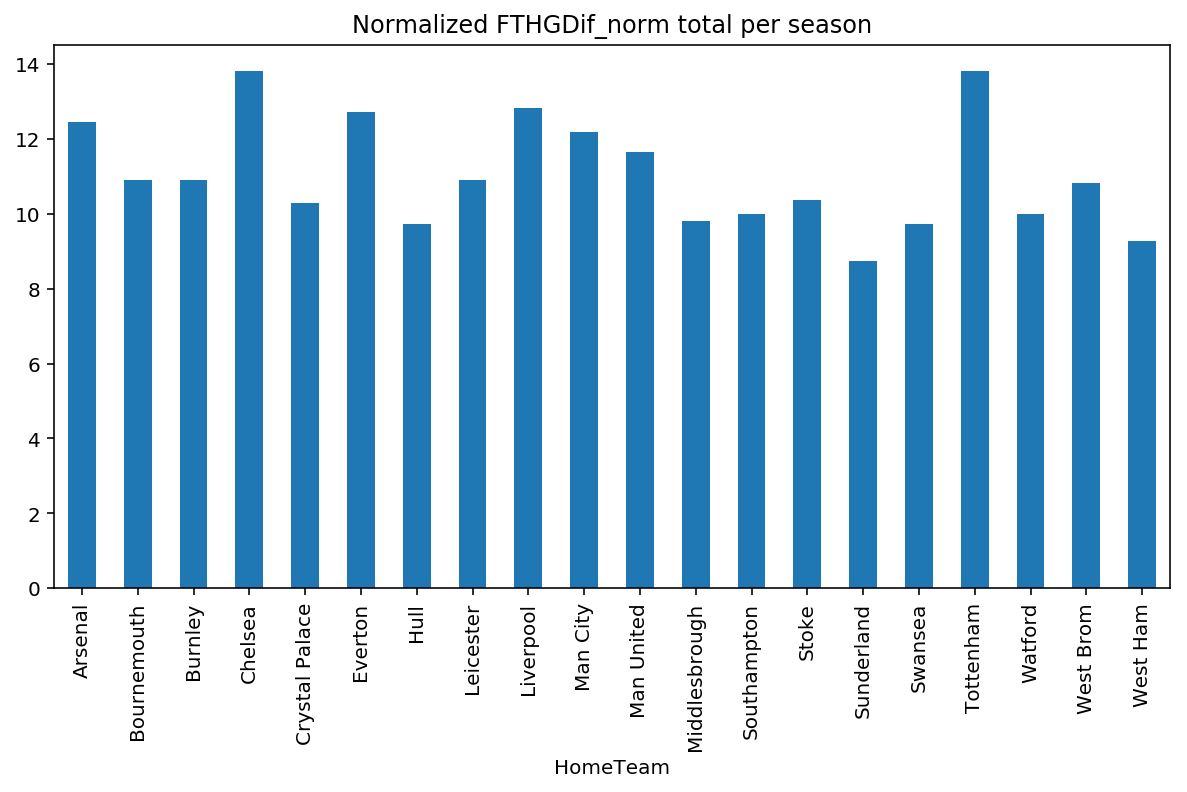

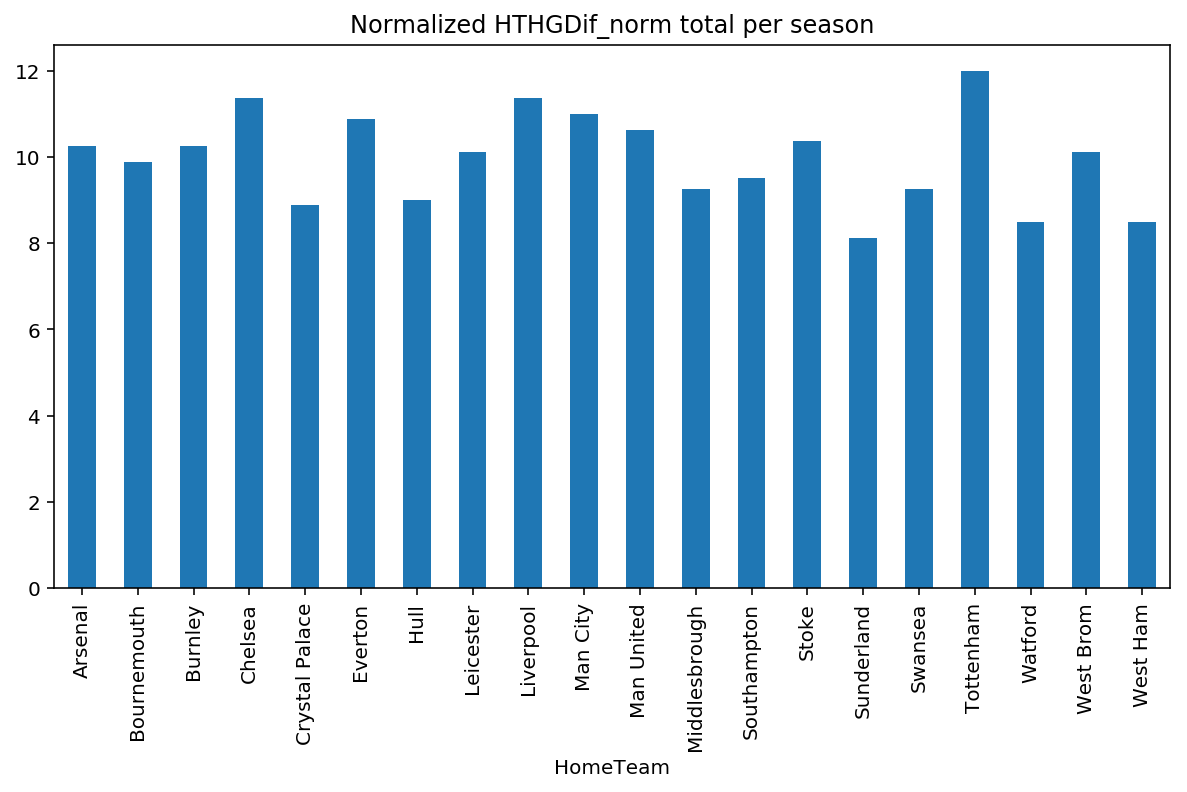

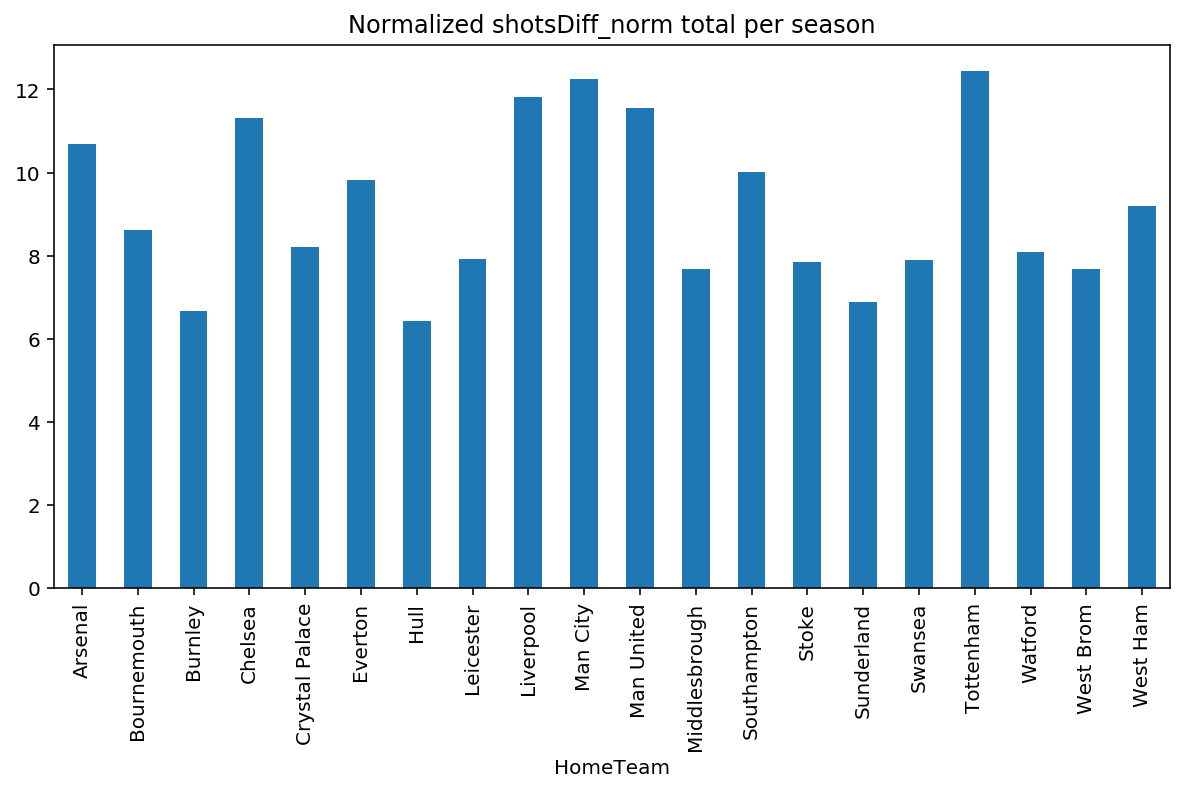

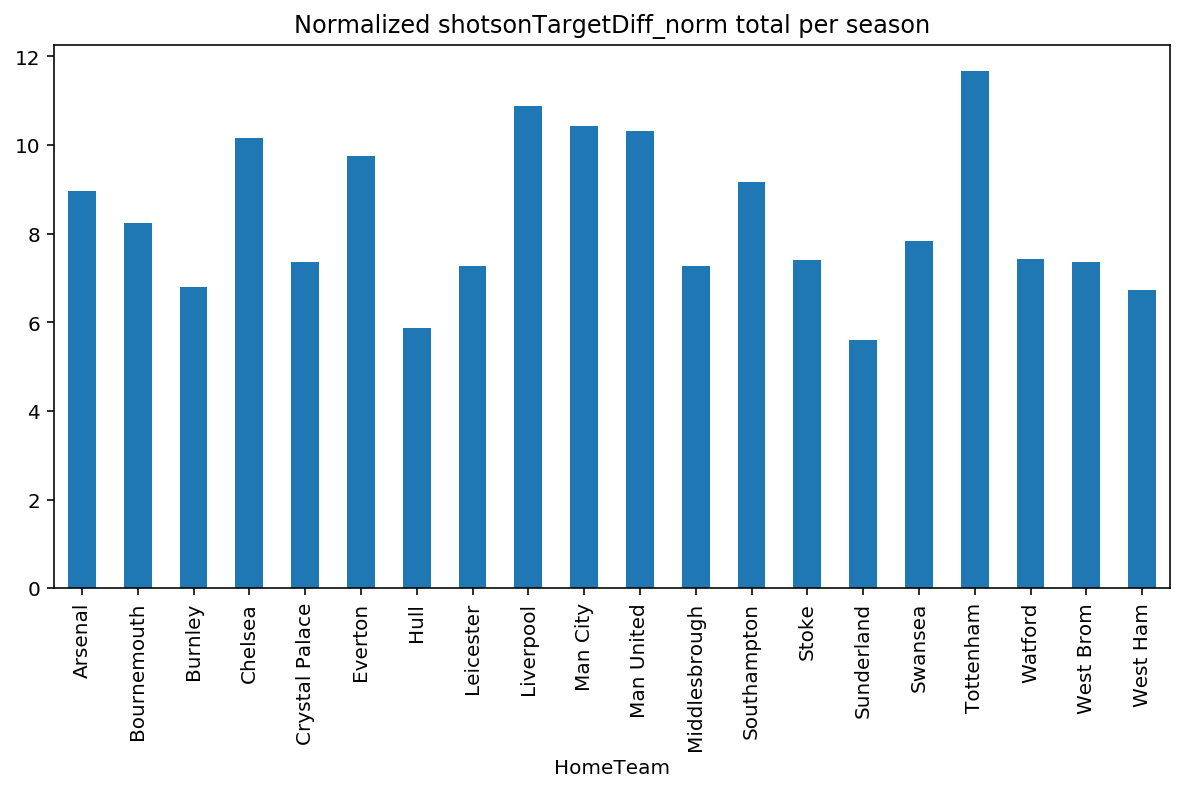

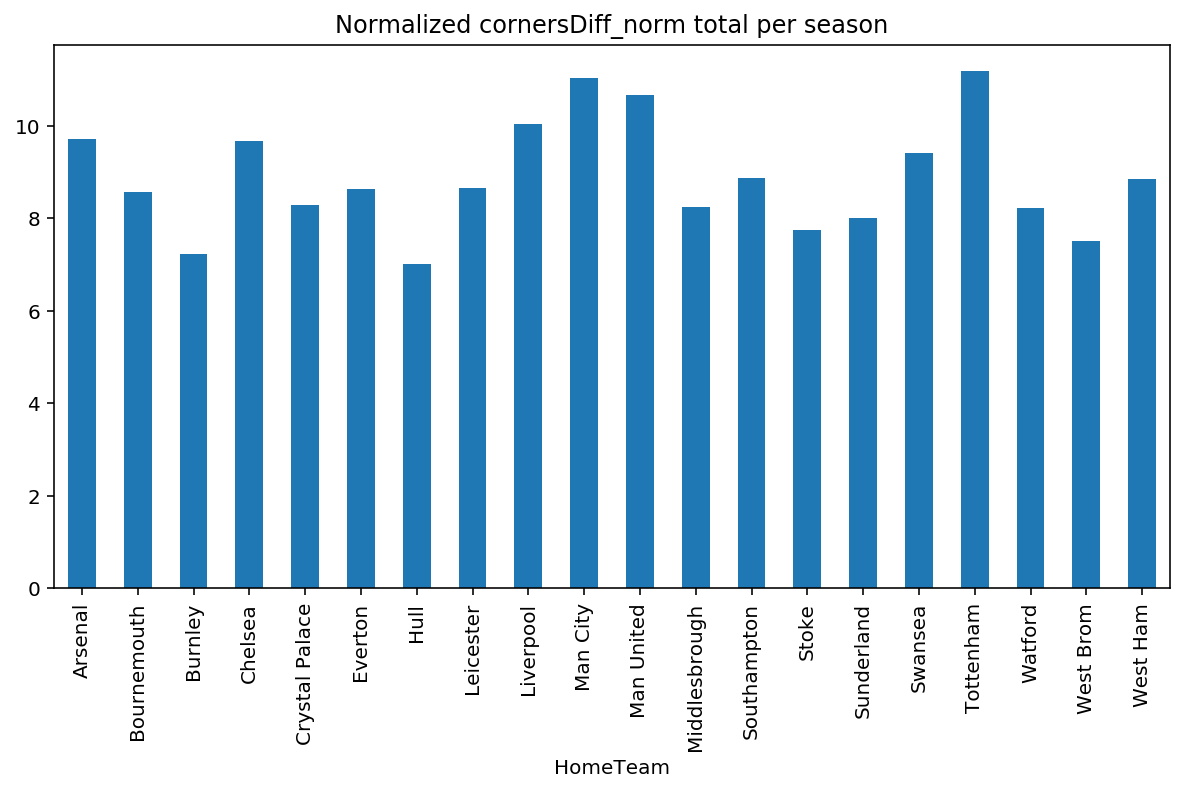

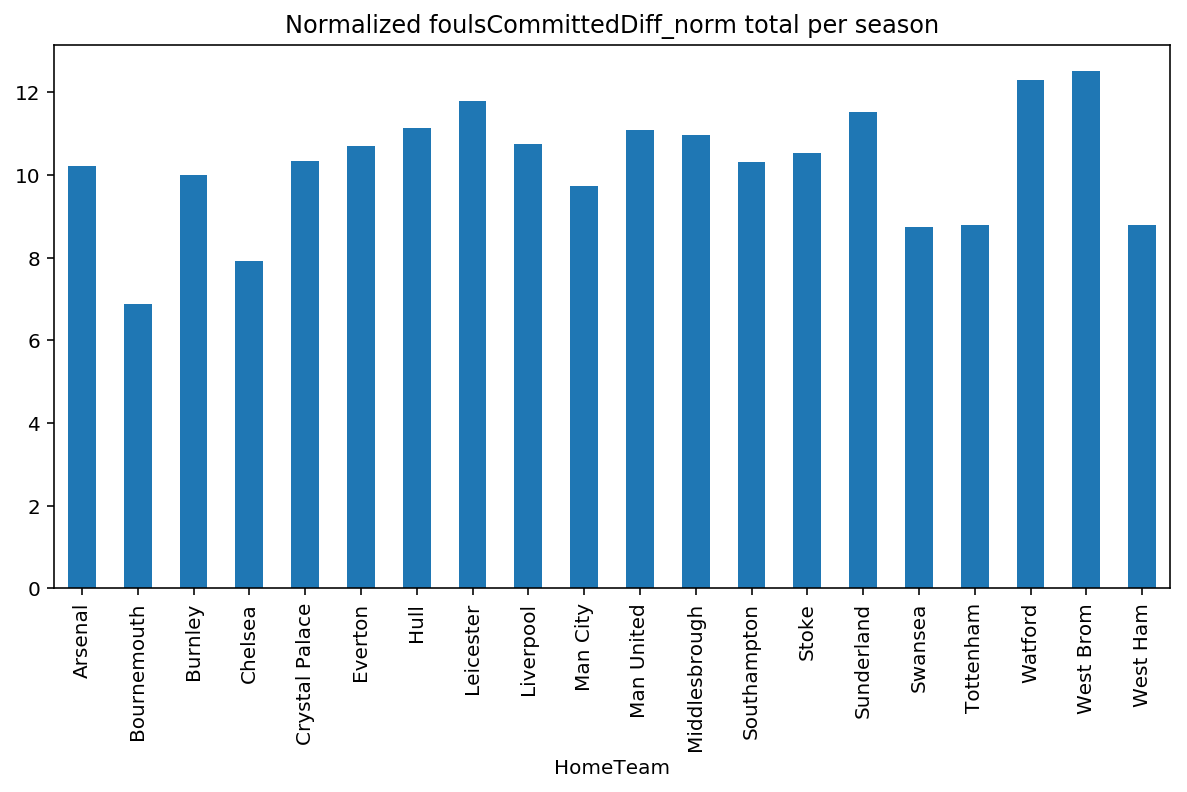

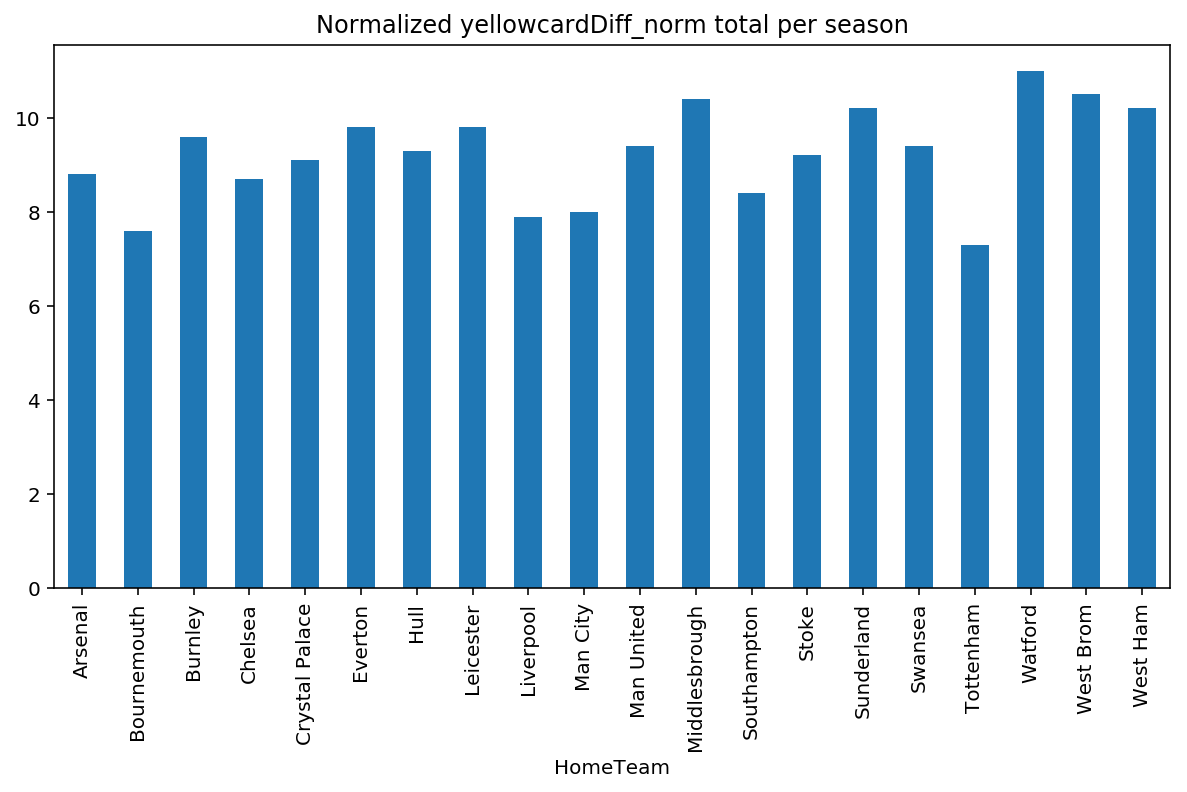

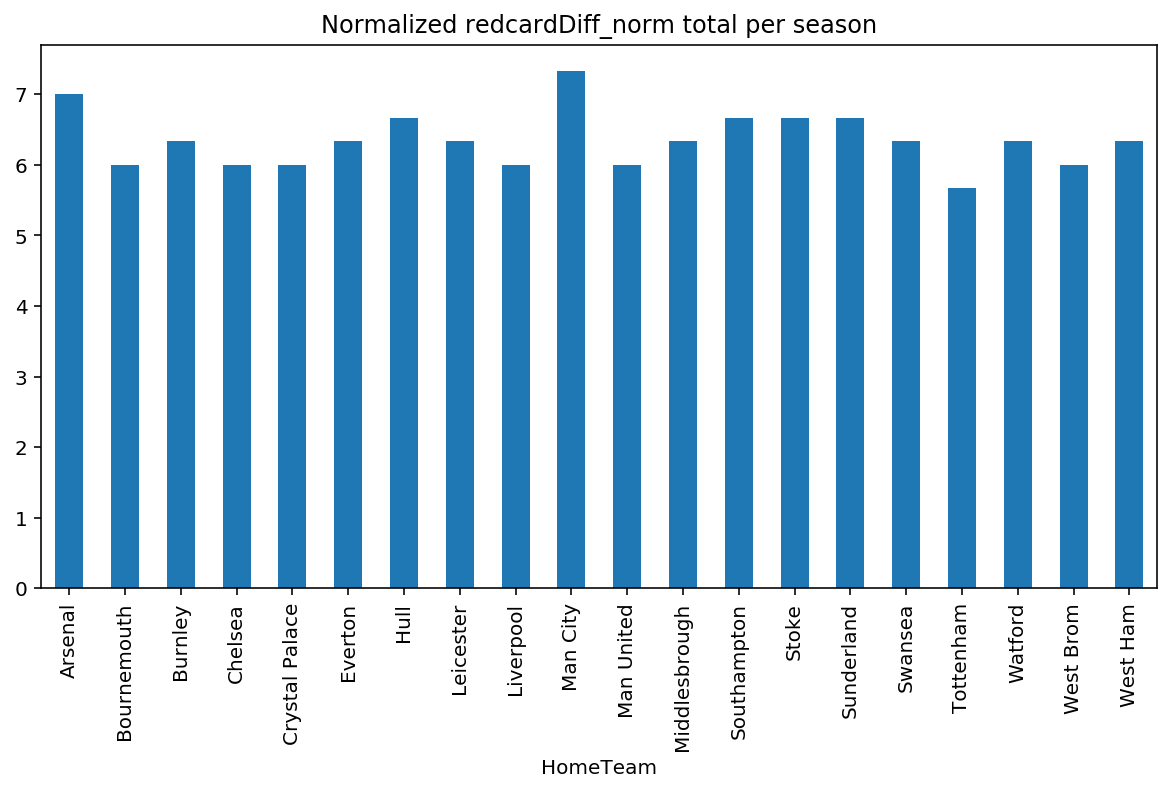

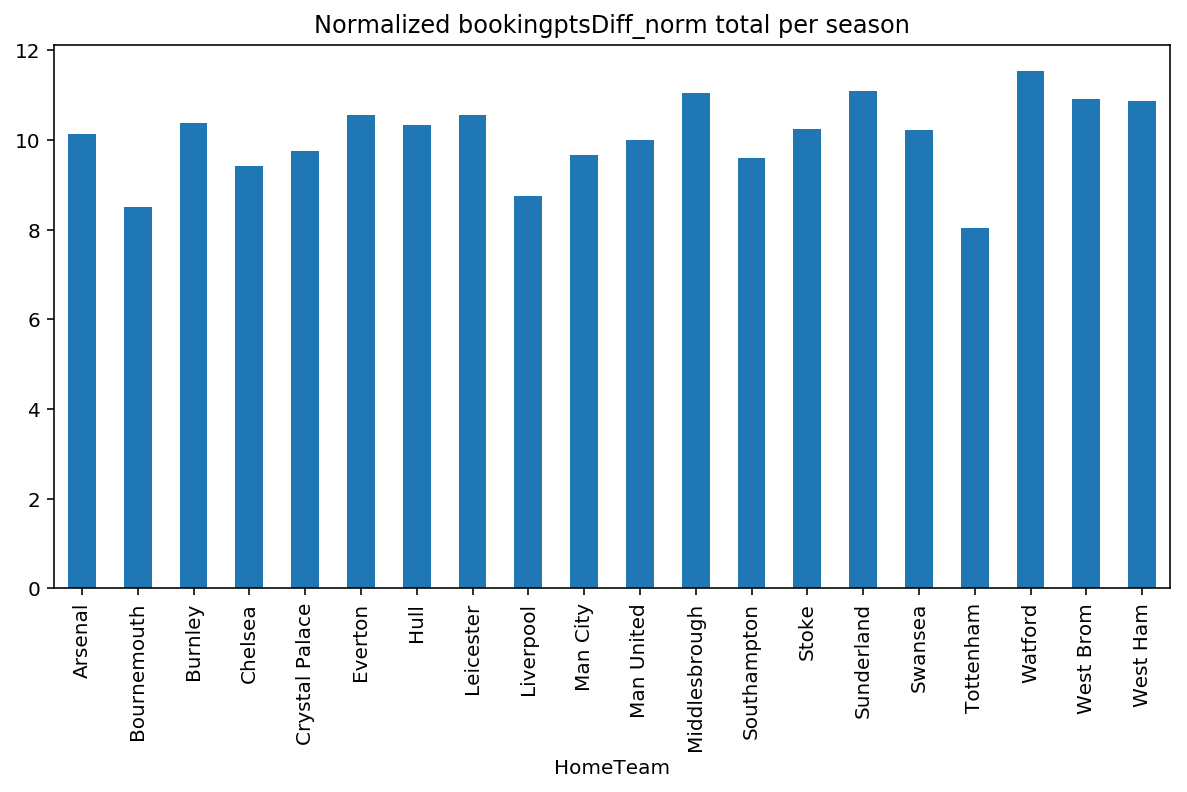

In [29]:
diff_norm_cols = ['FTHGDif_norm',
       'HTHGDif_norm', 'shotsDiff_norm', 'shotsonTargetDiff_norm',
       'cornersDiff_norm', 'foulsCommittedDiff_norm', 'yellowcardDiff_norm',
       'redcardDiff_norm', 'bookingptsDiff_norm']
for col in diff_norm_cols:
    df2.groupby('HomeTeam')[col].sum().plot(kind='bar', figsize=(10,5))
    plt.title('Normalized '+ col + ' total per season')
    plt.show()

In [30]:
FTR_res_keyH = {'H':1, 'A':-1, 'D':0}
EPL_res_keyH = {'H':3, 'A':0, 'D':1}
FTR_res_keyA = {'H':-1, 'A':1, 'D':0}
EPL_res_keyA = {'H':0, 'A':3, 'D':1}

In [31]:
df2[['HomeTeam','AwayTeam','FTR','FTHGDif']].head(10)

,HomeTeam,AwayTeam,FTR,FTHGDif
0,Burnley,Swansea,A,-1
1,Crystal Palace,West Brom,A,-1
2,Everton,Tottenham,D,0
3,Hull,Leicester,H,1
4,Man City,Sunderland,H,1
5,Middlesbrough,Stoke,D,0
6,Southampton,Watford,D,0
7,Arsenal,Liverpool,A,-1
8,Bournemouth,Man United,A,-2
9,Chelsea,West Ham,H,1


In [32]:
#results WRT to the hometeam and awayteam
df2['resultH'] = df2['FTR'].map(FTR_res_keyH)
df2['EPLresultH'] = df2['FTR'].map(EPL_res_keyH)
df2['resultA'] = df2['FTR'].map(FTR_res_keyA)
df2['EPLresultA'] = df2['FTR'].map(EPL_res_keyA)

In [33]:
df2.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HBP,ABP,FTHGDif,HTHGDif,shotsDiff,shotsonTargetDiff,cornersDiff,foulsCommittedDiff,yellowcardDiff,redcardDiff,bookingptsDiff,FTHGDif_norm,HTHGDif_norm,shotsDiff_norm,shotsonTargetDiff_norm,cornersDiff_norm,foulsCommittedDiff_norm,yellowcardDiff_norm,redcardDiff_norm,bookingptsDiff_norm,resultH,EPLresultH,resultA,EPLresultA
0,E0,13/08/16,Burnley,Swansea,0,1,A,0,0,D,J Moss,10,17,3,9,10,14,7,4,3,2,0,0,30,20,-1,0,-7,-6,3,-4,1,0,10,0.454545,0.500,0.301887,0.16,0.53125,0.391304,0.6,0.333333,0.625000,-1,0,1,3
1,E0,13/08/16,Crystal Palace,West Brom,0,1,A,0,0,D,C Pawson,14,13,4,3,12,15,3,6,2,2,0,0,20,20,-1,0,1,1,-3,-3,0,0,0,0.454545,0.500,0.452830,0.44,0.34375,0.434783,0.5,0.333333,0.541667,-1,0,1,3
2,E0,13/08/16,Everton,Tottenham,1,1,D,1,0,H,M Atkinson,12,13,6,4,10,14,5,6,0,0,0,0,0,0,0,1,-1,2,-1,-4,0,0,0,0.545455,0.625,0.415094,0.48,0.40625,0.391304,0.5,0.333333,0.541667,0,1,0,1
3,E0,13/08/16,Hull,Leicester,2,1,H,1,0,H,M Dean,14,18,5,5,8,17,5,3,2,2,0,0,20,20,1,1,-4,0,2,-9,0,0,0,0.636364,0.625,0.358491,0.40,0.50000,0.173913,0.5,0.333333,0.541667,1,3,-1,0
4,E0,13/08/16,Man City,Sunderland,2,1,H,1,0,H,R Madley,16,7,4,3,11,14,9,6,1,2,0,0,10,20,1,1,9,1,3,-3,-1,0,-10,0.636364,0.625,0.603774,0.44,0.53125,0.434783,0.4,0.333333,0.458333,1,3,-1,0


In [34]:
df2.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP', 'FTHGDif', 'HTHGDif',
       'shotsDiff', 'shotsonTargetDiff', 'cornersDiff', 'foulsCommittedDiff',
       'yellowcardDiff', 'redcardDiff', 'bookingptsDiff', 'FTHGDif_norm',
       'HTHGDif_norm', 'shotsDiff_norm', 'shotsonTargetDiff_norm',
       'cornersDiff_norm', 'foulsCommittedDiff_norm', 'yellowcardDiff_norm',
       'redcardDiff_norm', 'bookingptsDiff_norm', 'resultH', 'EPLresultH',
       'resultA', 'EPLresultA'],
      dtype='object')

In [36]:
df2[[  'resultH', 'EPLresultH', 'resultA', 'EPLresultA']].describe()

,resultH,EPLresultH,resultA,EPLresultA
count,380.000000,380.000000,380.000000,380.000000
mean,0.205263,1.697368,-0.205263,1.081579
std,0.859511,1.331769,0.859511,1.279503
min,-1.000000,0.000000,-1.000000,0.000000
25%,-1.000000,0.000000,-1.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,3.000000
max,1.000000,3.000000,1.000000,3.000000


In [38]:
df2[[ 'HomeTeam', 'AwayTeam', 'FTHGDif',
       'resultH', 'EPLresultH', 'resultA', 'EPLresultA']].head(20)

,HomeTeam,AwayTeam,FTHGDif,resultH,EPLresultH,resultA,EPLresultA
0,Burnley,Swansea,-1,-1,0,1,3
1,Crystal Palace,West Brom,-1,-1,0,1,3
2,Everton,Tottenham,0,0,1,0,1
3,Hull,Leicester,1,1,3,-1,0
4,Man City,Sunderland,1,1,3,-1,0
5,Middlesbrough,Stoke,0,0,1,0,1
6,Southampton,Watford,0,0,1,0,1
7,Arsenal,Liverpool,-1,-1,0,1,3
8,Bournemouth,Man United,-2,-1,0,1,3
9,Chelsea,West Ham,1,1,3,-1,0


In [39]:
HomePtTally_df = df2.groupby('HomeTeam')['HomeTeam', 'AwayTeam',
       'resultH', 'EPLresultH' ].sum().sort_values('EPLresultH', ascending=False)

In [40]:
AwayPtTally_df = df2.groupby('AwayTeam')['HomeTeam', 'AwayTeam',
        'resultA', 'EPLresultA'].sum().sort_values('EPLresultA', ascending=False)

In [41]:
HomePtTally_df.head()

,resultH,EPLresultH
HomeTeam,,
Tottenham,17,53
Chelsea,15,51
Arsenal,12,45
Everton,11,43
Liverpool,10,41


In [45]:
xx = pd.concat([HomePtTally_df, AwayPtTally_df], axis=1)

In [48]:
xx['EPLresult']= xx.EPLresultA + xx.EPLresultH
xx = xx.drop(['resultH','resultA'], axis=1)

In [49]:
xx.sort_values('EPLresult', ascending=False)

,EPLresultH,EPLresultA,EPLresult
Chelsea,51,42,93
Tottenham,53,33,86
Man City,40,38,78
Liverpool,41,35,76
Arsenal,45,30,75
Man United,34,35,69
Everton,43,18,61
Bournemouth,31,15,46
Southampton,24,22,46
West Brom,29,16,45


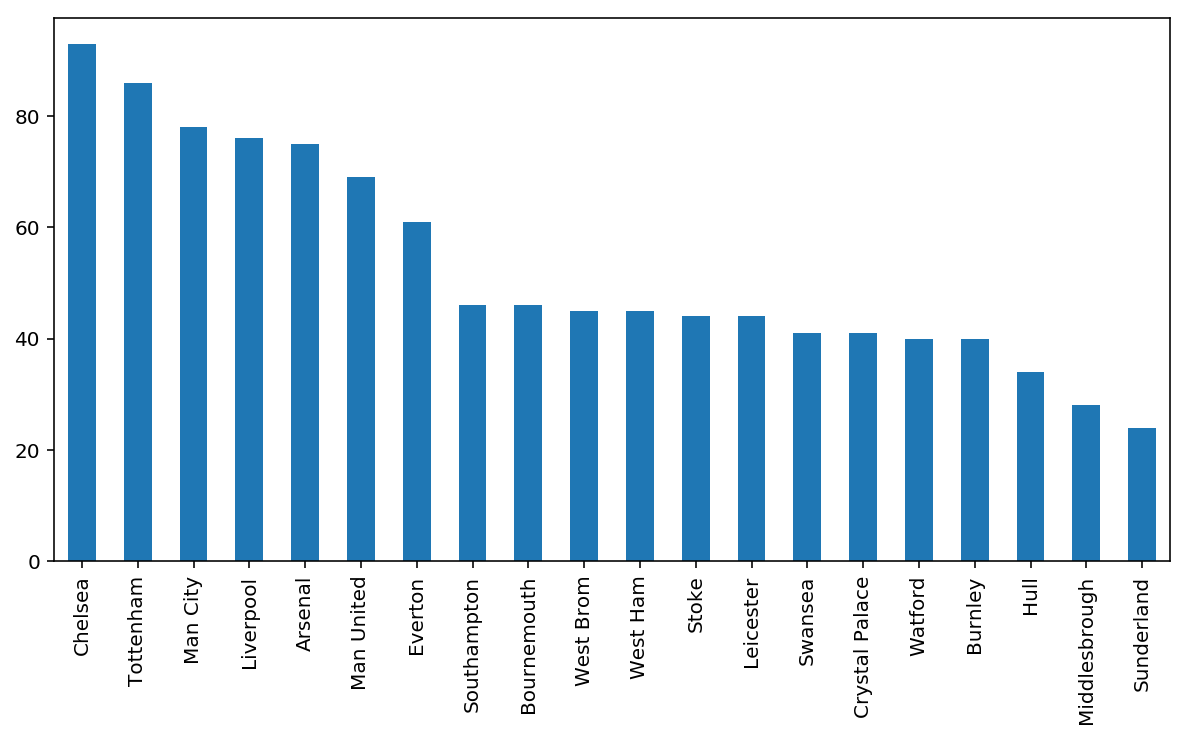

In [53]:
xx['EPLresult'].sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

In [61]:
df2.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HBP,ABP,FTHGDif,HTHGDif,shotsDiff,shotsonTargetDiff,cornersDiff,foulsCommittedDiff,yellowcardDiff,redcardDiff,bookingptsDiff,FTHGDif_norm,HTHGDif_norm,shotsDiff_norm,shotsonTargetDiff_norm,cornersDiff_norm,foulsCommittedDiff_norm,yellowcardDiff_norm,redcardDiff_norm,bookingptsDiff_norm,resultH,EPLresultH,resultA,EPLresultA
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1.597368,1.202632,0.705263,0.510526,14.013158,11.484211,4.813158,3.855263,11.063158,11.657895,5.678947,4.734211,1.744737,1.886842,0.055263,0.052632,18.828947,20.184211,0.394737,0.194737,2.528947,0.957895,0.944737,-0.594737,-0.142105,0.002632,-1.355263,0.581340,0.524342,0.481678,0.438316,0.467023,0.539359,0.485789,0.334211,0.530373,0.205263,1.697368,-0.205263,1.081579
std,1.306971,1.227862,0.857974,0.753108,5.878033,5.019462,2.817086,2.383452,3.468853,3.556378,3.084916,2.702562,1.256371,1.301647,0.240050,0.223591,13.797813,14.224649,1.907346,1.197611,9.344856,4.103325,4.663856,4.750667,1.632718,0.336823,17.755080,0.173395,0.149701,0.176318,0.164133,0.145746,0.206551,0.163272,0.112274,0.147959,0.859511,1.331769,0.859511,1.279503
min,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,-4.000000,-23.000000,-10.000000,-14.000000,-13.000000,-5.000000,-1.000000,-65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,9.000000,9.000000,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000,10.000000,10.000000,-1.000000,0.000000,-4.000000,-2.000000,-2.000000,-4.000000,-1.000000,0.000000,-10.000000,0.454545,0.500000,0.358491,0.320000,0.375000,0.391304,0.400000,0.333333,0.458333,-1.000000,0.000000,-1.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,11.000000,4.000000,3.000000,11.000000,12.000000,5.000000,4.000000,2.000000,2.000000,0.000000,0.000000,20.000000,20.000000,0.000000,0.000000,2.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.545455,0.500000,0.471698,0.440000,0.468750,0.521739,0.500000,0.333333,0.541667,0.000000,1.000000,0.000000,1.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,6.000000,5.000000,13.000000,14.000000,8.000000,6.000000,3.000000,3.000000,0.000000,0.000000,30.000000,30.000000,2.000000,1.000000,8.250000,3.000000,4.000000,3.000000,1.000000,0.000000,10.000000,0.727273,0.625000,0.589623,0.520000,0.562500,0.695652,0.600000,0.333333,0.625000,1.000000,3.000000,1.000000,3.000000
max,6.000000,7.000000,4.000000,4.000000,37.000000,29.000000,17.000000,15.000000,24.000000,24.000000,19.000000,15.000000,6.000000,6.000000,2.000000,1.000000,70.000000,85.000000,5.000000,4.000000,30.000000,15.000000,18.000000,10.000000,5.000000,2.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,3.000000


In [64]:
print(df2.FTHG.mean(), df2.FTAG.mean())
print(df2.FTHG[:-10].mean(), df2.FTAG[:-10].mean())

1.5973684210526315 1.2026315789473685
1.5918918918918918 1.1837837837837837


In [65]:
scs.skellam.pmf(0.0, df2.FTHG[:-10].mean(), df2.FTAG[:-10].mean())

0.24809376810717076

In [76]:
pprint

Pretty printing has been turned ON


In [90]:
HomeGoalDiff = np.linspace(-6,8,15)
win_prob_dict={}
win_prob_list=[]
for i in HomeGoalDiff:
    #probability of home team winning by __i__ goal
    win_prob_dict[i] = scs.skellam.pmf(i, df2.FTHG[:-10].mean(), df2.FTAG[:-10].mean())
    win_prob_list.append(scs.skellam.pmf(i, df2.FTHG[:-10].mean(), df2.FTAG[:-10].mean()))
print(win_prob_dict)
print()
print(win_prob_list)



{-6.0: 0.00031035888762206905, -5.0: 0.0016413894537650508, -4.0: 0.00735016409651767, -3.0: 0.027043427513958395, -2.0: 0.07841883834096516, -1.0: 0.16885506661651978, 0.0: 0.24809376810717076, 1.0: 0.22706765807563964, 2.0: 0.14180866650031265, 3.0: 0.06576355569936188, 4.0: 0.024035976580804717, 5.0: 0.007218011340943169, 6.0: 0.001835317866093923, 7.0: 0.0004041164773676143, 8.0: 7.840307476529532e-05}

[0.00031035888762206905, 0.0016413894537650508, 0.00735016409651767, 0.027043427513958395, 0.07841883834096516, 0.16885506661651978, 0.24809376810717076, 0.22706765807563964, 0.14180866650031265, 0.06576355569936188, 0.024035976580804717, 0.007218011340943169, 0.001835317866093923, 0.0004041164773676143, 7.840307476529532e-05]


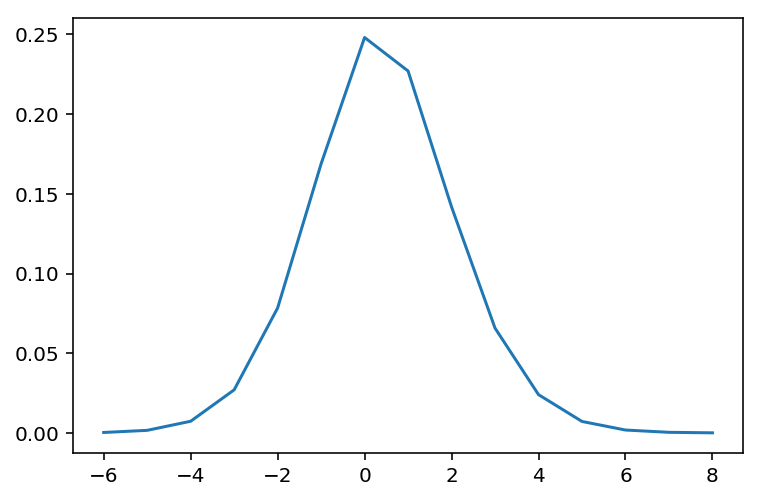

In [91]:
plt.plot(HomeGoalDiff, win_prob_list)

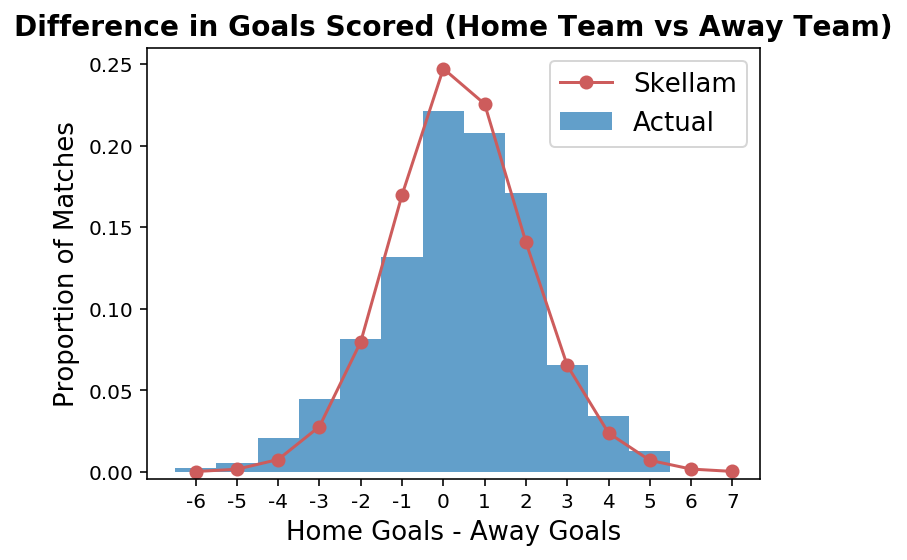

In [92]:
skellam_pred = [scs.skellam.pmf(i,  df2.FTHG.mean(),  df2.FTAG.mean()) for i in range(-6,8)]

plt.hist(df2.FTHG - df2.FTAG, range(-6,8), 
         alpha=0.7, label='Actual',normed=True)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Difference in Goals Scored (Home Team vs Away Team)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.26])
plt.tight_layout()
plt.show()

In [ ]:
fig,(ax1,ax2) = plt.subplots(2, 1)


chel_home = epl_1617[epl_1617['HomeTeam']=='Chelsea'][['HomeGoals']].apply(pd.value_counts,normalize=True)
chel_home_pois = [poisson.pmf(i,np.sum(np.multiply(chel_home.values.T,chel_home.index.T),axis=1)[0]) for i in range(8)]
sun_home = epl_1617[epl_1617['HomeTeam']=='Sunderland'][['HomeGoals']].apply(pd.value_counts,normalize=True)
sun_home_pois = [poisson.pmf(i,np.sum(np.multiply(sun_home.values.T,sun_home.index.T),axis=1)[0]) for i in range(8)]

chel_away = epl_1617[epl_1617['AwayTeam']=='Chelsea'][['AwayGoals']].apply(pd.value_counts,normalize=True)
chel_away_pois = [poisson.pmf(i,np.sum(np.multiply(chel_away.values.T,chel_away.index.T),axis=1)[0]) for i in range(8)]
sun_away = epl_1617[epl_1617['AwayTeam']=='Sunderland'][['AwayGoals']].apply(pd.value_counts,normalize=True)
sun_away_pois = [poisson.pmf(i,np.sum(np.multiply(sun_away.values.T,sun_away.index.T),axis=1)[0]) for i in range(8)]

ax1.bar(chel_home.index-0.4,chel_home.values,width=0.4,color="#034694",label="Chelsea")
ax1.bar(sun_home.index,sun_home.values,width=0.4,color="#EB172B",label="Sunderland")
pois1, = ax1.plot([i for i in range(8)], chel_home_pois,
                  linestyle='-', marker='o',label="Chelsea", color = "#0a7bff")
pois1, = ax1.plot([i for i in range(8)], sun_home_pois,
                  linestyle='-', marker='o',label="Sunderland", color = "#ff7c89")
leg=ax1.legend(loc='upper right', fontsize=12, ncol=2)
leg.set_title("Poisson                 Actual                ", prop = {'size':'14', 'weight':'bold'})
ax1.set_xlim([-0.5,7.5])
ax1.set_ylim([-0.01,0.65])
ax1.set_xticklabels([])
# mimicing the facet plots in ggplot2 with a bit of a hack
ax1.text(7.65, 0.585, '                Home                ', rotation=-90,
        bbox={'facecolor':'#ffbcf6', 'alpha':0.5, 'pad':5})
ax2.text(7.65, 0.585, '                Away                ', rotation=-90,
        bbox={'facecolor':'#ffbcf6', 'alpha':0.5, 'pad':5})

ax2.bar(chel_away.index-0.4,chel_away.values,width=0.4,color="#034694",label="Chelsea")
ax2.bar(sun_away.index,sun_away.values,width=0.4,color="#EB172B",label="Sunderland")
pois1, = ax2.plot([i for i in range(8)], chel_away_pois,
                  linestyle='-', marker='o',label="Chelsea", color = "#0a7bff")
pois1, = ax2.plot([i for i in range(8)], sun_away_pois,
                  linestyle='-', marker='o',label="Sunderland", color = "#ff7c89")
ax2.set_xlim([-0.5,7.5])
ax2.set_ylim([-0.01,0.65])
ax1.set_title("Number of Goals per Match (EPL 2016/17 Season)",size=14,fontweight='bold')
ax2.set_xlabel("Goals per Match",size=13)
ax2.text(-1.15, 0.9, 'Proportion of Matches', rotation=90, size=13)
plt.tight_layout()
plt.show()